# 背景概述

$\quad$Logistic回归是一个很好的模拟人脑决策过程的简单模型. 人们将做决策(0代指无动作、1代指作出动作)时的各个因素$\mathbf{x}$根据个人习惯(权重)$\mathbf{w}$作出(线性)组合$\mathbf{w}^\mathrm{T}\mathbf{x}$, 并且根据个人性格(激活函数)$\sigma(\cdot)$最终作出响应$y = \sigma(\mathbf{w}^\mathrm{T}\mathbf{x})$.

$\quad$一位顾客对购买汽车保险的意向会由哪些因素决定? 某公司为研究这一点, 收集了一些相关的顾客信息(共11个维度):
- 序号`id`: 从1开始计的整数.
- 性别`Gender`: 男性`Male`、女性`Female`;
- 年龄`Age`: 整数.
- 是否有驾照`Driving_License`: 二元值, 1代表有、0代表没有.
- 区域编码`Region_Code`: 整数.
- 是否有过汽车保险购买经历`Previously_Insured`: 二元值, 1代表有、0代表没有.
- 汽车车龄`Vehicle_Age`: 按年数分箱的定类值, 一年以内`< 1 Year`、一至两年`1-2 Year`、两年以上`> 2 Years`.
- 汽车是否有过损坏经历`Vehicle_Damage`: 二元值, `Yes`代表有、`No`代表没有.
- 年保费`Annual_Premium`: 浮点数.
- 销售渠道`Policy_Sales_Channel`: 浮点数, 为具体销售渠道的匿名编码(例如: 各家代理商、邮件订购、电话订购、直销、……).
- 服务天数`Vintage`: 浮点数, 为顾客在该公司注册身份、享受服务的天数.
- 是否有汽车保险购入的意向`Response`(**预测标签**): 二元值, 1代表有、0代表没有.

$\quad$本次上机作业将以这些数据建立Logistic回归模型, 以期实现汽车保险意向的预测与解释. 注意: 由于数据集是高度非均衡的, 所以模型的预测性能指标并不理想. 本次作业更多在于规范数据处理、模型训练与交叉验证的流程.

# 数据探索与清洗

$\quad$我们以[`pd.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv)方法读取数据集`car_ins_train_valid.csv`和`car_ins_test.csv`. 前者用于模型训练和验证(或说测试); 后者是一个**前瞻性测试集**(prospective test set), 缺少标签, 要求模型给出预测结果.

In [1]:
import pandas as pd
train_valid_set = pd.read_csv("./car_ins_train_valid.csv")

$\quad$**任务1**: 对(训练-验证)数据集的结构作初步探索.
- **任务1.1**: 运行下方前2个代码块, 在对应的答题区回答如下问题: (1) 除了`id`外, 哪些变量是数值变量、哪些是定类变量、哪些是定序变量? (2) 训练-验证集共有多少条数据? (3) 年保险费`Annual_Premium`和服务天数`Vintage`的取值数量级各自为多少？
- **任务1.2**: 在下方第3个代码块中, 基于[`df.plot()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html#pandas-dataframe-plot)方法, 完成函数`visualize_data()`的编写, 进行数据可视化:
  - `ax1`给出顾客年龄`Age`分布的箱线图`kind="box"`, 这可以用于取值分布的查看以及异常值监测.
  - `ax2`给出车龄`Vehicle_Age`分布的饼图`kind="pie"`;
  - `ax3`给出保险意向分布的柱状图`kind="bar"`.
- 函数`visualize_data()`的输入为:
  - `data`: 所用的原始数据, 本例即为`train_valid_set`;
  - `ax1`、`ax2`、`ax3`为各自画图所用的坐标纸;
  - `numerical_col`、`categorical_col`、`label_col`为作图所用的列标签, 在函数定义的代码中已经给出其默认值, 无需修改.
- 图片格式要求(示例):
  - 箱线图: 若`numerical_col`为`NUM`, 则图片标题为`NUM boxplot`;
  - 饼图: 若`categorical_col`为`CAT`, 则图片标题为`CAT pie plot`, 同时需要有比例百分数的标记(精确到小数点后一位, 可参考上机实习2), 且图片左侧不得显示任何字符(参数`ylabel`设置为空字符串`""`);
  - 柱状图: 若`label_col`为`LABEL`, 则图片标题为`LABEL bar plot`.

### 提示

- 数值(numerical)变量意味着其取值是连续的或可以看作连续的, 例如物品售价、年龄, 等等. 变量可取到的每个值**均匀、等间距地分布**在一定空间内.
- 定序(ordinal)离散变量意味着该离散数值的相对大小是有意义的, 例如职务等级、(分箱后的)年薪水平(低、中、高). 这类离散变量可以用保持原序的数值进行编码, 从而当作数值变量处理. 例如年薪水平“低”编码为0、“中”编码为1、“高”编码为2.
- 定类(nominal)离散变量意味着数值的相对大小无意义, 例如喜好的水果(苹果、橙子、菠萝), 这不能按0、1、2进行编码, 而是要采用特殊处理, 例如**独热编码**(one-hot encoding), 稍后将详细讨论.
- 如果你对这三者的关系还是理解得不太清楚, 可以仔细阅读后文, 体会我们对不同类型的变量的不同处理, 并*直接参照后文内容完成任务1.1的第(1)题*.

In [2]:
# view the first five rows of the train_valid dataset
train_valid_set.iloc[:, :]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [3]:
# view dataset description
train_valid_set.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


$\quad$大致了解了数据集的概况后, 你可以继续完成任务1.2, 在下面的代码块中编写可视化函数`visualize_data()`.

In [4]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def visualize_data(
    data: pd.DataFrame, ax1: matplotlib.axes.Axes, ax2: matplotlib.axes.Axes, ax3: matplotlib.axes.Axes,
    numerical_col: str="Age",
    categorical_col: str="Vehicle_Age",
    label_col: str="Response"
):
    ### BEGIN YOUR SOLUTION ###
    y_1 = pd.Series(data[numerical_col])
    y_1.plot(kind='box', ax= ax1, title="NUM boxplot", ylabel='Age')
    
    y_2 = pd.Series(data[categorical_col].value_counts())
    y_2.plot(kind='pie', title='CAT pie plot', autopct='%1.1f%%', ylabel='', ax=ax2)
    
    y_3 = pd.Series(data[label_col].value_counts())
    y_3.plot(kind='bar', ax=ax3, title='LABEL bar plot', ylabel='count')
    ### END YOUR SOLUTION ###

### 任务1.1答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# 定量变量：Age, Annual_Premium, Vintage
# 定序变量：Vehicle_Age
# 定类变量：Gender, Driving_Licence, Vehicle_Damage, Region_Code, Previously_Insured, Response
### END YOUR SOLUTION ###

$\quad$完成该函数的编写后, 请**务必**运行下面的代码块, 以输出对应的图片.

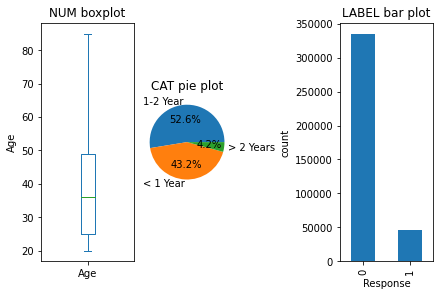

In [5]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, layout="constrained")
visualize_data(train_valid_set, ax1, ax2, ax3)
plt.show()

## 数据的清洗与加工

$\quad$显然, 原始数据需要经过预处理才能送入Logistic回归模型进行预测. 以下分别对数值变量、定序类别变量和定类类别变量进行考察.

$\quad$**数值变量**: 显然, 由于数量级差异巨大, 我们仍然需要对它们进行归一化处理. 具体如何选择呢? 一般讲,
- 最大-最小归一化适用的场景是**我们掌握着关于数据上下界的知识**. 这种归一化方法不改变特征分布的内在结构, 
- 均值-方差归一化适用的场景是**数据近似成正态分布**, 我们将这组特征作线性变换, “伸缩”成标准正态分布$\mathcal{N}(0, 1)$, 数值上更有利于学习算法的收敛.

在算法实践中, 往往更实用的是均值-方差归一化, 我们本次作业统一按照这一做法处理. **实现方法: 调用[`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler)模块**.当然, 如果你感兴趣, 也可以运行下面的代码块考察一下数据集内的数值变量取值分布. 

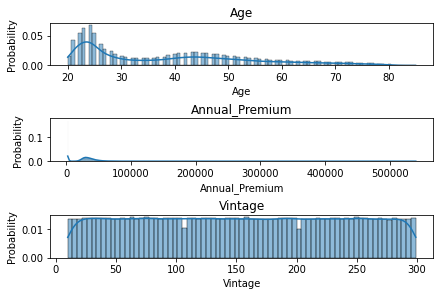

In [6]:
import seaborn as sns

_, axes = plt.subplots(3, 1, layout="constrained")
for i, col in enumerate(("Age", "Annual_Premium", "Vintage")):
    sns.histplot(train_valid_set[col], ax=axes[i], kde=True, stat="probability")
    axes[i].set_title(col)
plt.show()

$\quad$**定序变量**: 可以按原序将变量值映射到一系列(等距排布的)数值编码. 例如将薪水的低、中、高分别映射为0、1、2. **实现方法: 调用[`Series.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas-series-map)方法**.

$\quad$**定类变量**: 需要转换为**虚拟变量**(dummy variables), 即0/1独热编码. 例如男性编码为$(1, 0)$, 女性编码为$(0, 1)$. **实现方法: 调用[`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html#pandas-get-dummies)方法**.

$\quad$**任务2**: 完成函数`preprocess_features()`编写, 实现数据集特征的预处理. 输入:
- 训练特征集`X_train`、验证特征集`X_valid`, 它们都是(可做列索引的)`pd.DataFrame`格式;
- 数值变量列`numerical_cols`: 一系列字符串的列表, 包含了按照数值变量处理的那些列名;
- 定序变量列`ordinal_cols`: 一系列(二元)元组的列表, 每个元组记录了: 按照定序变量处理的列名、该列中按升序排列的值;
- 定类变量列`nominal_cols`: 一系列字符串的列表, 包含了按照定类变量处理的那些列的列名;
- 舍弃变量列`dropped_cols`: 一系列字符串的列表, 包含了舍弃的、不作为特征的那些列的列名.

函数需返回两个处理好的特征`X_train_processed`和`X_valid_processed`, 它们都应为`pd.DataFrame`.

$\quad$已经给出了函数若干参数的默认值, 本次作业将按照这套规程进行预处理. 简便起见, `id`、`Region_Code`、`Policy_Sales_Channel`这三行信息舍去.

### 提示

- 可以借助**生成式**(comprehension)给出`ordinal_cols`在进行列值转换时所需要的字典.

```python
for col, labels in ordinal_cols:
    label_map = {label: i for i, label in enumerate(labels)}
    # ...use label_map for further steps
```

- 建议大家在预处理时将结果赋给新变量, 而不是在原始`DataFrame`上进行原位修改. 此举在实践中也有助于保持中间步结果, 便于追溯和检查.

In [7]:
from typing import List, Tuple
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_features(
    X_train: pd.DataFrame, X_valid: pd.DataFrame,
    numerical_cols: List[str]=["Age", "Annual_Premium", "Vintage"],
    ordinal_cols: List[Tuple[str, List[str]]]=[("Vehicle_Age", ["< 1 Year", "1-2 Year", "> 2 Years"])],
    nominal_cols: List[str]=["Gender", "Vehicle_Damage", "Driving_License", "Previously_Insured"],
    dropped_cols: List[str]=["id", "Region_Code", "Policy_Sales_Channel"]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ### BEGIN YOUR SOLUTION ###
    # drop
    def processing(X):
        X_raw = X.drop(dropped_cols, axis=1)


        for col, labels in ordinal_cols:
            label_map = {label: i for i, label in enumerate(labels)}
        X_ordinal = X_raw.replace({"Vehicle_Age":label_map})


        X_oht = X_ordinal
        for col in nominal_cols:
            one_hot = pd.get_dummies(X_oht[col], dtype=int, prefix_sep="_", prefix=col)
            X_oht = pd.concat([X_oht, one_hot], axis=1)
            X_oht.drop(columns=col, inplace=True)

#         scaler = StandardScaler()
#         X_standard = X_oht
#         for col in numerical_cols:
#             standard_col = scaler.fit_transform(np.array(X_standard[col]).reshape(-1, 1))
#             X_standard.drop(columns=col, inplace=True)
#             X_standard[col]=standard_col
        
        return X_oht
    
#     data_train = processing(X_train)
#     data_valid = processing(X_valid)
    data_train = processing(X_train)
    data_valid = processing(X_valid)
    
    scaler = StandardScaler()
    data_train[numerical_cols] = scaler.fit_transform(data_train[numerical_cols])
    data_valid[numerical_cols] = scaler.transform(data_valid[numerical_cols])
    
    return (data_train, data_valid )
        
        
        
    
    ### END YOUR SOLUTION ###

$\quad$完成该函数后, 请**务必**运行下面的代码块先做初步检查.

In [31]:
X, y_true = train_valid_set.iloc[:, :-1], train_valid_set["Response"]
X_demo_train = X.iloc[:1000, :]
X_demo_valid = X.iloc[1000:2000, :].reset_index(drop=True)
preprocess_features(X_demo_train, X_demo_valid)[1]

,Age,Vehicle_Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Damage_No,Vehicle_Damage_Yes,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1
0,0.672881,1,0.957526,0.686294,0,1,0,1,0,1,1,0
1,-0.787144,0,0.699471,-0.959756,1,0,1,0,0,1,0,1
2,-0.787144,0,1.198817,-1.516509,1,0,1,0,0,1,0,1
3,-0.850623,0,-0.473285,-0.790310,1,0,1,0,0,1,0,1
4,0.672881,1,0.289365,1.521423,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.041061,0,-0.028103,-0.729793,0,1,1,0,0,1,0,1
996,1.117236,1,0.194220,1.678766,0,1,0,1,0,1,1,0
997,1.878988,1,-1.713447,1.581939,0,1,0,1,0,1,1,0
998,-0.914102,0,0.048848,-1.504405,0,1,1,0,0,1,0,1


$\quad$检查完成后, 可以运行下面的代码块对该函数进行测试. 测试通过情况将关系到该任务的得分. **请勿修改该代码块中的任何内容**.

In [9]:
### CAUTION: DO NOT MODIFY THIS CELL. ###

X_train_ = train_valid_set.iloc[:1000, :-1]
X_valid_ = train_valid_set.iloc[1000:2000, :-1].reset_index(drop=True)
test_columns = ['Age', 'Vehicle_Age', 'Annual_Premium', 'Vintage',
       'Gender_Male', 'Vehicle_Damage_Yes', 'Driving_License_1', 'Previously_Insured_1']
numerical_cols = ["Age", "Annual_Premium", "Vintage"]
ordinal_cols = [("Vehicle_Age", ["< 1 Year", "1-2 Year", "> 2 Years"])]

def test_preprocess_features_columns(X_train, X_valid, test_columns):
    X_train_processed, X_valid_processed = preprocess_features(X_train, X_valid)
    assert all(column in X_train_processed.columns for column in test_columns), "wrong training set column names."
    assert all(column in X_valid_processed.columns for column in test_columns), "wrong validation set column names."

def test_preprocess_features_numerical(X_train, X_valid, numerical_cols):
    X_train_processed, X_valid_processed = preprocess_features(X_train, X_valid, numerical_cols=numerical_cols)
    n_features = len(numerical_cols)
    mean_train, std_train = X_train[numerical_cols].mean(axis=0), X_train[numerical_cols].std(axis=0, ddof=0)
    mean_valid, std_valid = X_valid[numerical_cols].mean(axis=0), X_valid[numerical_cols].std(axis=0, ddof=0)
    np.testing.assert_allclose(
        X_train_processed[numerical_cols].mean(axis=0), np.zeros(n_features), atol=1.0e-5,
        err_msg="invalid X_train normalization: non-zero mean."
    )
    np.testing.assert_allclose(
        X_train_processed[numerical_cols].std(axis=0, ddof=0), np.ones(n_features), rtol=1.0e-3,
        err_msg="invalid X_train normalization: non-unit std."
    )
    np.testing.assert_allclose(
        X_valid_processed[numerical_cols].mean(axis=0), (mean_valid - mean_train) / std_train, rtol=1.0e-3,
        err_msg="invalid X_valid normalization: not using training parameters."
    )
    np.testing.assert_allclose(
        X_valid_processed[numerical_cols].std(axis=0, ddof=0), std_valid / std_train, rtol=1.0e-3,
        err_msg="invalid X_valid normalization: not using training parameters."
    )

def test_preprocess_features_ordinal(X_train, X_valid, ordinal_cols):
    X_train_processed, X_valid_processed = preprocess_features(X_train, X_valid, ordinal_cols=ordinal_cols)
    for col, labels in ordinal_cols:
        for i, label in enumerate(labels):
            assert set(X_train[X_train[col] == label].index) == set(X_train_processed[X_train_processed[col] == i].index),\
                f"invalid ordinal mapping for label {label} in {col} on training set."
            assert set(X_valid[X_valid[col] == label].index) == set(X_valid_processed[X_valid_processed[col] == i].index),\
                f"invalid ordinal mapping for label {label} in {col} on validation set."

try:
    print("columns:", end=" ")
    test_preprocess_features_columns(X_train_, X_valid_, test_columns)
    print("PASSED")
except Exception as err:
    print(err)

try:
    print("numerical scaling:", end=" ")
    test_preprocess_features_numerical(X_train_, X_valid_, numerical_cols)
    print("PASSED")
except Exception as err:
    print(err)

try:
    print("ordinal mapping:", end=" ")
    test_preprocess_features_ordinal(X_train_, X_valid_, ordinal_cols)
    print("PASSED")
except Exception as err:
    print(err)

columns: PASSED
numerical scaling: PASSED
ordinal mapping: PASSED


# 模型的训练与评估

$\quad$我们先完成模型训练与评估的各自流程, 并在下一部分将它们组装起来, 实现交叉验证. 简便起见, 先暂时分出一组训练集和验证集供函数编写调试使用. 请**务必**先运行下面的代码块.

In [11]:
from sklearn.model_selection import train_test_split
test_size = 0.3
X_train, X_valid, y_true_train, y_true_valid = train_test_split(X, y_true, test_size=test_size)
X_train, X_valid = preprocess_features(X_train, X_valid)

$\quad$**任务3**: 模型训练与评估组件的搭建.
- **任务3.1**: 完成函数`evaluate_model()`的编写, 输入:
  - 预测结果: `y_trues`、`y_scores`、`y_preds`, 各个数据集的真实标签/预测概率/预测标签组成的列表;
  - `labels`, 用于图例的文字标注;
  - `plot`: `bool`值参数(默认为`True`), 该函数是否作ROC曲线.
- 要求: (1) 以字典的形式返回分类指标accuracy、precision、recall、F1, 索引分别为`"accuracy"`、`"precision"`、`recall`、`f1`, 值是列表, 储存各组数据集上对应的某指标分值; (2) 根据函数`plot_roc()`(参见上机实习2, 以下已给出)绘制各组数据集上的ROC曲线, 并在图例报告各自的AUC值.
- **任务3.2**: 完成函数`train_and_eval()`的编写, 输入: 训练与验证数据`X_train, X_valid, y_true_train, y_true_valid`、是否作图`plot`, 返回二元元组: 训练好的模型、指标字典. 该函数用于搭建模型, 并完成训练与评估.

In [12]:
def plot_roc(y_trues, y_scores, labels):
    from sklearn.metrics import roc_curve, roc_auc_score
    # figure setup
    plt.title("ROC curve of the Logistic Regression model")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    for y_true, y_score, label in zip(y_trues, y_scores, labels):
        # metrics preparation
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{label} AUC = {auc:.2f}")
    plt.legend()
    plt.show()

In [51]:
from typing import Dict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(
    y_trues: List, y_scores: List, y_preds: List,
    labels: List[str], plot: bool=True
) -> Dict:
    ### BEGIN YOUR SOLUTION ###
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i, j in zip(y_trues, y_preds):
#         y_true = np.reshape(i, newshape=(-1))
#         y_pred = np.reshape(j, newshape=(-1))

        accuracy_i = accuracy_score(y_true=i, y_pred=j)
        accuracy.append(accuracy_i)
        precision_i = precision_score(y_true=i, y_pred=j)
        precision.append(precision_i)
        recall_i = recall_score(y_true=i, y_pred=j)
        recall.append(recall_i)
        f1_i = f1_score(y_true=i, y_pred=j)
        f1.append(f1_i)
        
    score_dict = dict({"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1})
    
    if plot:
        for label in labels:
            plot_roc(y_trues, y_scores, labels)
    
    return score_dict
    
    ### END YOUR SOLUTION ###

$\quad$完成任务3.1后, 可以运行下面的代码块对该函数进行测试. 测试情况将关系到该任务的得分. **请勿修改代码块中的任何内容**.

In [52]:
### CAUTION: DO NOT MODIFY THIS CELL. ###

test_y_trues = [np.array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])]
test_y_preds = [np.array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1])]
test_metrics = [0.4666666666666667, 0.5, 0.375, 0.42857142857142855]

def test_evaluate_model_keys(y_trues, y_preds, test_metrics):
    metrics = evaluate_model(y_trues, [], y_preds, [], plot=False)
    assert set(metrics.keys()) == {"accuracy", "precision", "recall", "f1"}, "wrong metrics names."

def test_evaluate_model_values(y_trues, y_preds, test_metrics):
    metrics = evaluate_model(y_trues, [], y_preds, [], plot=False)
    np.testing.assert_allclose(
        [metrics["accuracy"][0], metrics["precision"][0], metrics["recall"][0], metrics["f1"][0]], test_metrics, rtol=1.0e-3,
        err_msg="wrong metrics values."
    )

try:
    print("keys:", end=" ")
    test_evaluate_model_keys(test_y_trues, test_y_preds, test_metrics)
    print("PASSED")
except Exception as err:
    print(err)

try:
    print("values:", end=" ")
    test_evaluate_model_values(test_y_trues, test_y_preds, test_metrics)
    print("PASSED")
except Exception as err:
    print(err)

keys: PASSED
values: PASSED


$\quad$测试通过后, 你可以继续完成任务3.2: `train_and_eval()`函数的编写.

In [15]:
from sklearn.linear_model import LogisticRegression
def train_and_eval(X_train, X_valid, y_true_train, y_true_valid, plot: bool=True) -> Tuple[object, Dict]:
    ### BEGIN YOUR SOLUTION ###
    clf = LogisticRegression().fit(X_train, y_true_train)
    y_pred_train = clf.predict(X_train)
    y_pred_valid = clf.predict(X_valid)
    
    y_true = [y_true_train, y_true_valid]
    y_pred = [y_pred_train, y_pred_valid]
    
    metrics = evaluate_model(y_true, [], y_pred, [], plot=False)
    
    return (clf, metrics)
    
    ### END YOUR SOLUTION ###

$\quad$完成任务3.2后, 请**务必**运行下面的代码块以做检查.

In [16]:
clf, metrics = train_and_eval(X_train, X_valid, y_true_train, y_true_valid)
metrics

{'accuracy': [0.8770953908897352, 0.8779355041851434],
 'precision': [0.24390243902439024, 0.11764705882352941],
 'recall': [0.0003051850947599719, 0.00014344115326687227],
 'f1': [0.00060960741282614, 0.00028653295128939826]}

# 交叉验证

$\quad$**任务4**: 完成训练-验证集上的5折交叉验证, 并对测试集给出前瞻性预测结果.
- **任务4.1**: 完成函数`cross_validation()`的编写, 输入:
  - 待拆分的数据集`X`与`y_true`;
  - 交叉验证折数`n_splits`(默认为5).
- 返回平均指标字典, 格式与任务3.1一致: 索引为`"accuracy"`、`"precision"`、`"recall"`、`"f1"`, 值为二元列表, 分别为训练集(平均)指标、验证集(平均)指标. 在本次作业中, 不涉及超参数优化, 交叉验证只作练习使用.
- **任务4.2**: 运行对应的代码块, 在全部训练-验证集上进行模型训练并考察模型系数, 根据系数正负解释每个(或组)特征对汽车保险意向的影响因素.
- **任务4.3**: 完成函数`predict()`的编写, 输入模型`clf`与测试集文件名`dataset_name`, 返回含特征和预测标签的`pd.DataFrame`, 标签为单加一列, 列名为`Response_Pred`.

### 提示
- 许多我们需要用到的组件在早先已经定义好. 尤其重要的可供调用的函数包括: `preprocess_features`、`train_and_eval`.
- 注意`X`为`pd.DataFrame`, 其索引需要使用`loc`或`iloc`函数.
- 注意: 模型训练后, 一对独热变量所对应的系数近似为相反数, 所以你需要挑出的实际上可能是“两对”特征.

In [44]:
from sklearn.model_selection import KFold

def cross_validation(X, y_true, n_splits: int=5) -> Dict:
    ### BEGIN YOUR SOLUTION ###
    kf = KFold(n_splits= n_splits, shuffle=True)
    accs = {"train":[], "valid":[]}
    metrics = []
    for train, valid in kf.split(X):
        X_train_init, X_valid_init, y_true_train, y_true_valid = X.iloc[train], X.iloc[valid], y_true.iloc[train], y_true.iloc[valid]
        X_train, X_valid = preprocess_features(X_train_init, X_valid_init)
        clf = LogisticRegression().fit(X_train, y_true_train)
        y_pred_train = clf.predict(X_train)
        y_pred_valid = clf.predict(X_valid)
        
        metric = evaluate_model([y_true_train, y_true_train], [], [y_pred_train, y_pred_valid], [], plot=False)
        
        metrics.append(metric)
    
    return metrics
        
    
        
    ### END YOUR SOLUTION ###

In [25]:
kf = KFold(n_splits=5)
for train , valid in kf.split(X_train):
    print(train, valid)

[ 53356  53357  53358 ... 266773 266774 266775] [    0     1     2 ... 53353 53354 53355]
[     0      1      2 ... 266773 266774 266775] [ 53356  53357  53358 ... 106708 106709 106710]
[     0      1      2 ... 266773 266774 266775] [106711 106712 106713 ... 160063 160064 160065]
[     0      1      2 ... 266773 266774 266775] [160066 160067 160068 ... 213418 213419 213420]
[     0      1      2 ... 213418 213419 213420] [213421 213422 213423 ... 266773 266774 266775]


$\quad$完成任务4.1后, 请**务必**运行下面的代码块, 完成交叉验证的过程.

In [50]:
cross_validation(X, y_true)

ValueError: Found input variables with inconsistent numbers of samples: [304887, 76222]

$\quad$完成交叉验证后, 你可以轻松一下! 继续完成任务4.2: 运行下面的代码块, 在全部数据集上完成训练, 并打印模型系数, 在对应答题区写下你的分析.

In [26]:
X_dummy_valid = X
X_processed = preprocess_features(X, X_dummy_valid)[0]
clf = LogisticRegression().fit(X_processed, y_true)
clf.coef_

### 任务4.2答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
#
### END YOUR SOLUTION ###

array([[-2.48908378e-01,  7.37338077e-01,  4.69611320e-02,
        -8.34648014e-04, -4.82452027e-02,  5.88347404e-02,
        -1.00706775e+00,  1.01765729e+00, -6.09930451e-01,
         6.20519989e-01,  2.00312990e+00, -1.99254036e+00]])

$\quad$完成后, 你可以继续完成任务4.3: 编写函数`predict()`, 并运行最后一个代码块, 保存文件, 并将该文件在教学网提交窗口上以附件形式上传.

In [ ]:
def predict(clf: object, dataset_name: str) -> pd.DataFrame:
    ### BEGIN YOUR SOLUTION ###
    
    ### END YOUR SOLUTION ###

In [ ]:
test_data = predict(clf, "/bohr/MLInChem-w8y2/v1/car_ins_test.csv")
test_data.to_csv("car_ins_test_predictions.csv", sep="\t", index=None)

# 